In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import jax
print(jax.devices())

[CpuDevice(id=0)]


In [2]:
import sys

sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

### Creating Boundary Conditions by Masking

In [3]:
def add_smart_speaker(domain, center, source, inner_size=[1.0, 1.0], wall_width=0.1):
    cx, cy = center
    w_in, h_in = inner_size
    t = wall_width
    
    # --- 1. Calculate Geometry (Center-based) ---
    
    # A. Back Wall (Bottom)
    # Spans full width (inner + 2*walls) to seal corners
    # Center X: Same as speaker center (cx)
    # Center Y: Shift down by half height + half thickness
    back_size = [w_in + 2*t, t]
    back_pos  = [cx, cy - h_in/2 - t/2]
    
    # B. Left Wall
    # Center X: Shift left by half width + half thickness
    # Center Y: Same as speaker center (cy) - assuming simple U shape
    left_size = [t, h_in]
    left_pos  = [cx - w_in/2 - t/2, cy]
    
    # C. Right Wall
    # Center X: Shift right by half width + half thickness
    right_size = [t, h_in]
    right_pos  = [cx + w_in/2 + t/2, cy]
    
    # --- 2. Add Obstacles ---
    domain.add_rectangular_obstacle(back_pos, back_size)
    domain.add_rectangular_obstacle(left_pos, left_size)
    domain.add_rectangular_obstacle(right_pos, right_size)
    
    # --- 3. Paint Materials ---
    X, Y = domain.grids
    
    # Helper must match your Domain's "Center" logic!
    def get_mask(p, s):
        return (
            (X >= p[0] - s[0]/2) & (X <= p[0] + s[0]/2) & 
            (Y >= p[1] - s[1]/2) & (Y <= p[1] + s[1]/2)
        )

    speaker_mask = (get_mask(back_pos, back_size) | 
                    get_mask(left_pos, left_size) | 
                    get_mask(right_pos, right_size))
    
    domain.materials[speaker_mask] = 1.0
    
    # --- 4. Add Source ---
    domain.add_source(source)
    print(f"✅ Smart Speaker added at {center}")

✅ Smart Speaker added at [5, 5]


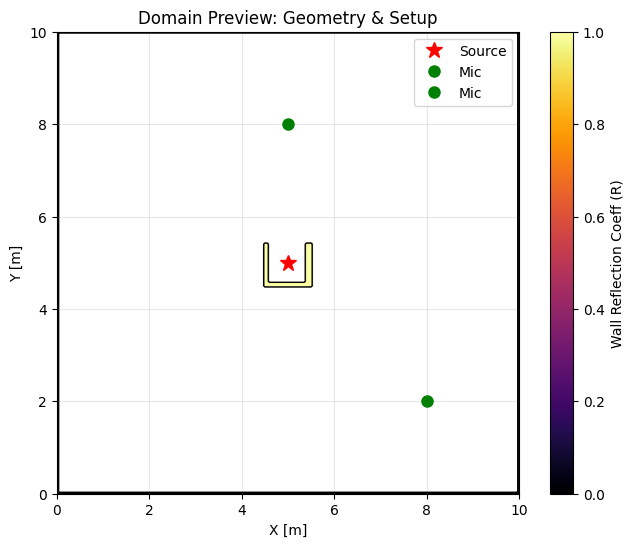

Compiling geometry for GPU...
Warming up JIT compiler...


TypeError: 'float' object is not subscriptable

In [5]:
import numpy as np
from src.core import Domain2D
from src.solvers import Wave, WaveJAX
from src.components import RickerSource, Listener
from src.visualization import PhysicsAnimator

# 1. Setup Scene
room = Domain2D(length=[10, 10], dx=0.05, R=0.0)

# 2. Populate Scene (Geometry + Source + Material)
add_smart_speaker(room, center=[5, 5], source = RickerSource(pos=[5, 5], peak_freq=200.0, delay=0.01), inner_size=[0.8, 0.8])

# 3. Add a Microphone
room.add_listener(Listener(pos=[5, 8])) # In front
room.add_listener(Listener(pos=[8, 2])) # To the side (Shadow)

# 4. DEBUG: Check coordinates instantly!
room.preview() 
# ^ If there are gaps in the box, you will see them here immediately.

# 5. Run Physics
# The Solver now pulls everything from the domain
solver = WaveJAX(domain=room, c=343.0)

In [ ]:
solver.reset()
animator = PhysicsAnimator(solver = solver, total_time=0.1)
animator.run()

fig = animator.create_animation(skip_frames=10)
fig.show()

In [ ]:
plt.plot(*solver.domain.listeners[0].get_time_series(), alpha = 0.6)
plt.plot(*solver.domain.listeners[1].get_time_series(), alpha = 0.6)

In [ ]:
plt.plot(*solver.domain.listeners[0].get_time_series(), alpha = 0.6)
plt.plot(*solver.domain.listeners[1].get_time_series(), alpha = 0.6)